In [9]:
# Pandas 
import pandas as pd

# ChEMBL Database
from chembl_webresource_client.new_client import new_client

# NumPy
import numpy as np

#RD-Kit
from rdkit import Chem
from rdkit.Chem import Descriptors, Lipinski

# Seaborn
import seaborn as sns
sns.set(style='ticks')

# Matplot
import matplotlib.pyplot as plt

#Mann-Whitney test

def mannwhitney(descriptor, verbose=False):
  # https://machinelearningmastery.com/nonparametric-statistical-significance-tests-in-python/
  from numpy.random import seed
  from numpy.random import randn
  from scipy.stats import mannwhitneyu
  seed(1)
  selection = [descriptor, 'class']
  df = df_2class[selection]
  active = df[df['class'] == 'active']
  active = active[descriptor]
  selection = [descriptor, 'class']
  df = df_2class[selection]
  inactive = df[df['class'] == 'inactive']
  inactive = inactive[descriptor]
  stat, p = mannwhitneyu(active, inactive)
  alpha = 0.05
  if p > alpha:
    interpretation = 'Same distribution (fail to reject H0)'
  else:
    interpretation = 'Different distribution (reject H0)'
  
  results = pd.DataFrame({'Descriptor':descriptor,
                          'Statistics':stat,
                          'p':p,
                          'alpha':alpha,
                          'Interpretation':interpretation}, index=[0])
  filename = 'mannwhitneyu_' + descriptor + '.csv'
  results.to_csv(filename)

  return results

# Padel Descriptor
from padelpy import padeldescriptor

# Lazy Predict
import lazypredict
from lazypredict.Supervised import LazyRegressor

# SKLearn
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor

# Glob
import glob



In [2]:
# Target search
target = new_client.target
target_query = target.search('Serotonin transporter')
targets = pd.DataFrame.from_dict(target_query)
targets

,cross_references,organism,pref_name,score,species_group_flag,target_chembl_id,target_components,target_type,tax_id
0,"[{'xref_id': 'P31645', 'xref_name': None, 'xre...",Homo sapiens,Serotonin transporter,20.0,False,CHEMBL228,"[{'accession': 'P31645', 'component_descriptio...",SINGLE PROTEIN,9606.0
1,"[{'xref_id': 'P31652', 'xref_name': None, 'xre...",Rattus norvegicus,Serotonin transporter,20.0,False,CHEMBL313,"[{'accession': 'P31652', 'component_descriptio...",SINGLE PROTEIN,10116.0
2,"[{'xref_id': 'NBK23133', 'xref_name': 'Seroton...",Mus musculus,Serotonin transporter,20.0,False,CHEMBL4642,"[{'accession': 'Q60857', 'component_descriptio...",SINGLE PROTEIN,10090.0
3,"[{'xref_id': 'Q9MYX0', 'xref_name': None, 'xre...",Macaca mulatta,Serotonin transporter,20.0,False,CHEMBL5453,"[{'accession': 'Q9MYX0', 'component_descriptio...",SINGLE PROTEIN,9544.0
4,[],Rattus norvegicus,Monoamine transporters; Norepinephrine & serot...,20.0,False,CHEMBL2096672,"[{'accession': 'P31652', 'component_descriptio...",SELECTIVITY GROUP,10116.0
...,...,...,...,...,...,...,...,...,...
410,[],Homo sapiens,Patatin-like phospholipase domain-containing p...,2.0,False,CHEMBL3822353,"[{'accession': 'Q96AD5', 'component_descriptio...",SINGLE PROTEIN,9606.0
411,[],Homo sapiens,Sarcoplasmic/endoplasmic reticulum calcium ATPase,2.0,False,CHEMBL3831290,"[{'accession': 'Q93084', 'component_descriptio...",PROTEIN FAMILY,9606.0
412,[],Mus musculus,Sarcoplasmic/endoplasmic reticulum calcium ATP...,2.0,False,CHEMBL4523144,"[{'accession': 'O55143', 'component_descriptio...",SINGLE PROTEIN,10090.0
413,[],Mus musculus,Sarcoplasmic/endoplasmic reticulum calcium ATP...,2.0,False,CHEMBL4523404,"[{'accession': 'Q8R429', 'component_descriptio...",SINGLE PROTEIN,10090.0


In [3]:
selected_target = targets.target_chembl_id[0]
selected_target
## Confirmatory step to see if the ID of the selected molecules, matches to that of our desired molecule.

'CHEMBL228'

In [5]:
activity = new_client.activity
res = activity.filter(target_chembl_id=selected_target).filter(standard_type="IC50")

## In this step we find molecules that have shown any sort of molecular interaction to our desired molecule 
## NOTE: Bioactivity can give both Benificial and Adverse affects? 
## Bio Activity is measured in terms of IC50, which is the amount of drug moleucle required to inhibit the biological process by half

In [6]:
df = pd.DataFrame.from_dict(res)

In [7]:
df.to_csv('human_sero_bioactivity_data_raw.csv', index=False)

In [54]:
df2 = df.standard_value.replace( 0, )
df2 = df[df.standard_value.notna()]
df2 = df2[df.canonical_smiles.notna()]
df2
#Notna (Only considers values that are non Zero in nature)
# Standard value is the IC50 value
# Canonical values describe each molecule in our raw data in a single line but include crucial information like structure
#which can further determine the function.

<ipython-input-54-8c5e8be1af59>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df2 = df2[df.canonical_smiles.notna()]


,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,105351,[],CHEMBL806861,Inhibition of [3H]citalopram binding to seroto...,B,None,None,BAO_0000190,BAO_0000221,...,Homo sapiens,Serotonin transporter,9606,None,None,IC50,nM,UO_0000065,None,5160.0
1,None,105826,[],CHEMBL808141,Binding affinity towards serotonin transporter...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serotonin transporter,9606,None,None,IC50,nM,UO_0000065,None,1.15
2,None,106988,[],CHEMBL873260,Binding affinity towards serotonin transporter...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serotonin transporter,9606,None,None,IC50,nM,UO_0000065,None,4.2
3,None,108742,[],CHEMBL806861,Inhibition of [3H]citalopram binding to seroto...,B,None,None,BAO_0000190,BAO_0000221,...,Homo sapiens,Serotonin transporter,9606,None,None,IC50,nM,UO_0000065,None,33.4
4,None,111537,[],CHEMBL806861,Inhibition of [3H]citalopram binding to seroto...,B,None,None,BAO_0000190,BAO_0000221,...,Homo sapiens,Serotonin transporter,9606,None,None,IC50,nM,UO_0000065,None,27.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4400,None,20667770,[],CHEMBL4619933,Antagonist activity at SERT receptor (unknown ...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serotonin transporter,9606,None,None,IC50,nM,UO_0000065,None,203.0
4401,None,20667771,[],CHEMBL4619933,Antagonist activity at SERT receptor (unknown ...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serotonin transporter,9606,None,None,IC50,nM,UO_0000065,None,341.6
4402,None,20667772,[],CHEMBL4619933,Antagonist activity at SERT receptor (unknown ...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serotonin transporter,9606,None,None,IC50,nM,UO_0000065,None,13.41
4403,Active,20723982,[],CHEMBL4510297,Serotonin-uptake assay,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serotonin transporter,9606,None,None,IC50,nM,UO_0000065,None,13.0


In [56]:
len(df2.canonical_smiles.unique())

2944

In [57]:
df2_nr = df2.drop_duplicates(['canonical_smiles'])
df2_nr

,activity_comment,activity_id,activity_properties,assay_chembl_id,assay_description,assay_type,assay_variant_accession,assay_variant_mutation,bao_endpoint,bao_format,...,target_organism,target_pref_name,target_tax_id,text_value,toid,type,units,uo_units,upper_value,value
0,None,105351,[],CHEMBL806861,Inhibition of [3H]citalopram binding to seroto...,B,None,None,BAO_0000190,BAO_0000221,...,Homo sapiens,Serotonin transporter,9606,None,None,IC50,nM,UO_0000065,None,5160.0
1,None,105826,[],CHEMBL808141,Binding affinity towards serotonin transporter...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serotonin transporter,9606,None,None,IC50,nM,UO_0000065,None,1.15
2,None,106988,[],CHEMBL873260,Binding affinity towards serotonin transporter...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serotonin transporter,9606,None,None,IC50,nM,UO_0000065,None,4.2
3,None,108742,[],CHEMBL806861,Inhibition of [3H]citalopram binding to seroto...,B,None,None,BAO_0000190,BAO_0000221,...,Homo sapiens,Serotonin transporter,9606,None,None,IC50,nM,UO_0000065,None,33.4
4,None,111537,[],CHEMBL806861,Inhibition of [3H]citalopram binding to seroto...,B,None,None,BAO_0000190,BAO_0000221,...,Homo sapiens,Serotonin transporter,9606,None,None,IC50,nM,UO_0000065,None,27.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4398,None,20667768,[],CHEMBL4619933,Antagonist activity at SERT receptor (unknown ...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serotonin transporter,9606,None,None,IC50,nM,UO_0000065,None,536.9
4399,None,20667769,[],CHEMBL4619933,Antagonist activity at SERT receptor (unknown ...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serotonin transporter,9606,None,None,IC50,nM,UO_0000065,None,303.8
4400,None,20667770,[],CHEMBL4619933,Antagonist activity at SERT receptor (unknown ...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serotonin transporter,9606,None,None,IC50,nM,UO_0000065,None,203.0
4401,None,20667771,[],CHEMBL4619933,Antagonist activity at SERT receptor (unknown ...,B,None,None,BAO_0000190,BAO_0000357,...,Homo sapiens,Serotonin transporter,9606,None,None,IC50,nM,UO_0000065,None,341.6


In [58]:
selection = ['molecule_chembl_id','canonical_smiles','standard_value']
df3 = df2_nr[selection]
df3

# for the scope of the study we have only considered the 3 columns 
# Uinque identifier of the query molecule, Chemical structure and IC50 values

,molecule_chembl_id,canonical_smiles,standard_value
0,CHEMBL322923,COC(=O)C1=C(c2ccc(Cl)c(Cl)c2)CC2CCC1C2,5160.0
1,CHEMBL435341,C/C=C\c1ccc([C@H]2CC3CCC([C@H]2C(=O)OC)N3C)cc1,1.15
2,CHEMBL311347,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccc(I)cc1)N2C,4.2
3,CHEMBL100941,COC(=O)C1C2CCC(C2)CC1c1ccc(Cl)c(Cl)c1,33.4
4,CHEMBL87031,COC(=O)C1C(c2ccc(Cl)c(Cl)c2)CC2CCC1N2C,27.6
...,...,...,...
4398,CHEMBL4638599,O=c1n(CCCCN2CCN(c3cccc4sccc34)CC2)nc2ccccn12,536.9
4399,CHEMBL4644352,O=c1n(CCCCN2CCN(c3cccc4sccc34)CC2)nc2c(F)cccn12,303.8
4400,CHEMBL4634009,COc1cccc2nn(CCCCN3CCN(c4cccc5sccc45)CC3)c(=O)n12,203.0
4401,CHEMBL4644391,N#Cc1ccc2nn(CCCCN3CCN(c4cccc5sccc45)CC3)c(=O)n2c1,341.6


In [59]:
df3.to_csv('human_sero_bioactivity_data_02_preprocessed.csv', index=False)

In [4]:
df4 = pd.read_csv('human_sero_bioactivity_data_02_preprocessed.csv')

NameError: name 'pd' is not defined

In [61]:
bioactivity_threshold = []
for i in df4.standard_value:
  if float(i) >= 10000:
    bioactivity_threshold.append("inactive")
  elif float(i) <= 1000:
    bioactivity_threshold.append("active")
  else:
    bioactivity_threshold.append("intermediate")

In [62]:
bioactivity_class = pd.Series(bioactivity_threshold, name='class')
df5 = pd.concat([df4, bioactivity_class], axis=1)
df5

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL322923,COC(=O)C1=C(c2ccc(Cl)c(Cl)c2)CC2CCC1C2,5160.00,intermediate
1,CHEMBL435341,C/C=C\c1ccc([C@H]2CC3CCC([C@H]2C(=O)OC)N3C)cc1,1.15,active
2,CHEMBL311347,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccc(I)cc1)N2C,4.20,active
3,CHEMBL100941,COC(=O)C1C2CCC(C2)CC1c1ccc(Cl)c(Cl)c1,33.40,active
4,CHEMBL87031,COC(=O)C1C(c2ccc(Cl)c(Cl)c2)CC2CCC1N2C,27.60,active
...,...,...,...,...
2939,CHEMBL4638599,O=c1n(CCCCN2CCN(c3cccc4sccc34)CC2)nc2ccccn12,536.90,active
2940,CHEMBL4644352,O=c1n(CCCCN2CCN(c3cccc4sccc34)CC2)nc2c(F)cccn12,303.80,active
2941,CHEMBL4634009,COc1cccc2nn(CCCCN3CCN(c4cccc5sccc45)CC3)c(=O)n12,203.00,active
2942,CHEMBL4644391,N#Cc1ccc2nn(CCCCN3CCN(c4cccc5sccc45)CC3)c(=O)n2c1,341.60,active


In [63]:
df5.to_csv('human_sero_bioactivity_03_data_curated.csv', index=False)

In [2]:
dfa = pd.read_csv('human_sero_bioactivity_03_data_curated.csv')
dfa

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL322923,COC(=O)C1=C(c2ccc(Cl)c(Cl)c2)CC2CCC1C2,5160.00,intermediate
1,CHEMBL435341,C/C=C\c1ccc([C@H]2CC3CCC([C@H]2C(=O)OC)N3C)cc1,1.15,active
2,CHEMBL311347,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccc(I)cc1)N2C,4.20,active
3,CHEMBL100941,COC(=O)C1C2CCC(C2)CC1c1ccc(Cl)c(Cl)c1,33.40,active
4,CHEMBL87031,COC(=O)C1C(c2ccc(Cl)c(Cl)c2)CC2CCC1N2C,27.60,active
...,...,...,...,...
2938,CHEMBL4638599,O=c1n(CCCCN2CCN(c3cccc4sccc34)CC2)nc2ccccn12,536.90,active
2939,CHEMBL4644352,O=c1n(CCCCN2CCN(c3cccc4sccc34)CC2)nc2c(F)cccn12,303.80,active
2940,CHEMBL4634009,COc1cccc2nn(CCCCN3CCN(c4cccc5sccc45)CC3)c(=O)n12,203.00,active
2941,CHEMBL4644391,N#Cc1ccc2nn(CCCCN3CCN(c4cccc5sccc45)CC3)c(=O)n2c1,341.60,active


In [3]:
df_no_smiles = dfa.drop(columns='canonical_smiles')

In [4]:
smiles = []

for i in dfa.canonical_smiles.tolist():
  cpd = str(i).split('.')
  cpd_longest = max(cpd, key = len)
  smiles.append(cpd_longest)

smiles = pd.Series(smiles, name = 'canonical_smiles')

## Bring canonical notation to the last column for ease in data analysis and visualzation

In [5]:
df_clean_smiles = pd.concat([df_no_smiles,smiles], axis=1)
df_clean_smiles

,molecule_chembl_id,standard_value,class,canonical_smiles
0,CHEMBL322923,5160.00,intermediate,COC(=O)C1=C(c2ccc(Cl)c(Cl)c2)CC2CCC1C2
1,CHEMBL435341,1.15,active,C/C=C\c1ccc([C@H]2CC3CCC([C@H]2C(=O)OC)N3C)cc1
2,CHEMBL311347,4.20,active,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccc(I)cc1)N2C
3,CHEMBL100941,33.40,active,COC(=O)C1C2CCC(C2)CC1c1ccc(Cl)c(Cl)c1
4,CHEMBL87031,27.60,active,COC(=O)C1C(c2ccc(Cl)c(Cl)c2)CC2CCC1N2C
...,...,...,...,...
2938,CHEMBL4638599,536.90,active,O=c1n(CCCCN2CCN(c3cccc4sccc34)CC2)nc2ccccn12
2939,CHEMBL4644352,303.80,active,O=c1n(CCCCN2CCN(c3cccc4sccc34)CC2)nc2c(F)cccn12
2940,CHEMBL4634009,203.00,active,COc1cccc2nn(CCCCN3CCN(c4cccc5sccc45)CC3)c(=O)n12
2941,CHEMBL4644391,341.60,active,N#Cc1ccc2nn(CCCCN3CCN(c4cccc5sccc45)CC3)c(=O)n2c1


In [7]:
# Inspired by: https://codeocean.com/explore/capsules?query=tag:data-curation

def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [8]:
df_lipinski = lipinski(df_clean_smiles.canonical_smiles)
df_lipinski
## we get all this information from cananonical smiles data

,MW,LogP,NumHDonors,NumHAcceptors
0,311.208,4.74000,0.0,2.0
1,299.414,3.45900,0.0,3.0
2,385.245,3.03050,0.0,3.0
3,313.224,4.68620,0.0,2.0
4,328.239,3.73270,0.0,3.0
...,...,...,...,...
2938,407.543,3.31310,0.0,7.0
2939,425.533,3.45220,0.0,7.0
2940,437.569,3.32170,0.0,8.0
2941,432.553,3.18478,0.0,8.0


In [9]:
df_lipinski

,MW,LogP,NumHDonors,NumHAcceptors
0,311.208,4.74000,0.0,2.0
1,299.414,3.45900,0.0,3.0
2,385.245,3.03050,0.0,3.0
3,313.224,4.68620,0.0,2.0
4,328.239,3.73270,0.0,3.0
...,...,...,...,...
2938,407.543,3.31310,0.0,7.0
2939,425.533,3.45220,0.0,7.0
2940,437.569,3.32170,0.0,8.0
2941,432.553,3.18478,0.0,8.0


In [10]:
dfa

,molecule_chembl_id,canonical_smiles,standard_value,class
0,CHEMBL322923,COC(=O)C1=C(c2ccc(Cl)c(Cl)c2)CC2CCC1C2,5160.00,intermediate
1,CHEMBL435341,C/C=C\c1ccc([C@H]2CC3CCC([C@H]2C(=O)OC)N3C)cc1,1.15,active
2,CHEMBL311347,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccc(I)cc1)N2C,4.20,active
3,CHEMBL100941,COC(=O)C1C2CCC(C2)CC1c1ccc(Cl)c(Cl)c1,33.40,active
4,CHEMBL87031,COC(=O)C1C(c2ccc(Cl)c(Cl)c2)CC2CCC1N2C,27.60,active
...,...,...,...,...
2938,CHEMBL4638599,O=c1n(CCCCN2CCN(c3cccc4sccc34)CC2)nc2ccccn12,536.90,active
2939,CHEMBL4644352,O=c1n(CCCCN2CCN(c3cccc4sccc34)CC2)nc2c(F)cccn12,303.80,active
2940,CHEMBL4634009,COc1cccc2nn(CCCCN3CCN(c4cccc5sccc45)CC3)c(=O)n12,203.00,active
2941,CHEMBL4644391,N#Cc1ccc2nn(CCCCN3CCN(c4cccc5sccc45)CC3)c(=O)n2c1,341.60,active


In [11]:
df_combined = pd.concat([dfa,df_lipinski], axis=1)
df_combined

,molecule_chembl_id,canonical_smiles,standard_value,class,MW,LogP,NumHDonors,NumHAcceptors
0,CHEMBL322923,COC(=O)C1=C(c2ccc(Cl)c(Cl)c2)CC2CCC1C2,5160.00,intermediate,311.208,4.74000,0.0,2.0
1,CHEMBL435341,C/C=C\c1ccc([C@H]2CC3CCC([C@H]2C(=O)OC)N3C)cc1,1.15,active,299.414,3.45900,0.0,3.0
2,CHEMBL311347,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccc(I)cc1)N2C,4.20,active,385.245,3.03050,0.0,3.0
3,CHEMBL100941,COC(=O)C1C2CCC(C2)CC1c1ccc(Cl)c(Cl)c1,33.40,active,313.224,4.68620,0.0,2.0
4,CHEMBL87031,COC(=O)C1C(c2ccc(Cl)c(Cl)c2)CC2CCC1N2C,27.60,active,328.239,3.73270,0.0,3.0
...,...,...,...,...,...,...,...,...
2938,CHEMBL4638599,O=c1n(CCCCN2CCN(c3cccc4sccc34)CC2)nc2ccccn12,536.90,active,407.543,3.31310,0.0,7.0
2939,CHEMBL4644352,O=c1n(CCCCN2CCN(c3cccc4sccc34)CC2)nc2c(F)cccn12,303.80,active,425.533,3.45220,0.0,7.0
2940,CHEMBL4634009,COc1cccc2nn(CCCCN3CCN(c4cccc5sccc45)CC3)c(=O)n12,203.00,active,437.569,3.32170,0.0,8.0
2941,CHEMBL4644391,N#Cc1ccc2nn(CCCCN3CCN(c4cccc5sccc45)CC3)c(=O)n2c1,341.60,active,432.553,3.18478,0.0,8.0


In [12]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [13]:
df_combined.standard_value.describe()

count      2943.000000
mean       3996.423075
std       19506.585637
min           0.002000
25%          18.000000
50%         150.100000
75%        1419.000000
max      436100.000000
Name: standard_value, dtype: float64

In [14]:
def norm_value(input):
    norm = []

    for i in input['standard_value']:
        if i > 100000000:
          i = 100000000
        norm.append(i)

    input['standard_value_norm'] = norm
    x = input.drop('standard_value', 1)
        
    return x

In [15]:
df_norm = norm_value(df_combined)
df_norm

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,standard_value_norm
0,CHEMBL322923,COC(=O)C1=C(c2ccc(Cl)c(Cl)c2)CC2CCC1C2,intermediate,311.208,4.74000,0.0,2.0,5160.00
1,CHEMBL435341,C/C=C\c1ccc([C@H]2CC3CCC([C@H]2C(=O)OC)N3C)cc1,active,299.414,3.45900,0.0,3.0,1.15
2,CHEMBL311347,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccc(I)cc1)N2C,active,385.245,3.03050,0.0,3.0,4.20
3,CHEMBL100941,COC(=O)C1C2CCC(C2)CC1c1ccc(Cl)c(Cl)c1,active,313.224,4.68620,0.0,2.0,33.40
4,CHEMBL87031,COC(=O)C1C(c2ccc(Cl)c(Cl)c2)CC2CCC1N2C,active,328.239,3.73270,0.0,3.0,27.60
...,...,...,...,...,...,...,...,...
2938,CHEMBL4638599,O=c1n(CCCCN2CCN(c3cccc4sccc34)CC2)nc2ccccn12,active,407.543,3.31310,0.0,7.0,536.90
2939,CHEMBL4644352,O=c1n(CCCCN2CCN(c3cccc4sccc34)CC2)nc2c(F)cccn12,active,425.533,3.45220,0.0,7.0,303.80
2940,CHEMBL4634009,COc1cccc2nn(CCCCN3CCN(c4cccc5sccc45)CC3)c(=O)n12,active,437.569,3.32170,0.0,8.0,203.00
2941,CHEMBL4644391,N#Cc1ccc2nn(CCCCN3CCN(c4cccc5sccc45)CC3)c(=O)n2c1,active,432.553,3.18478,0.0,8.0,341.60


In [16]:
df_norm.standard_value_norm.describe()

count      2943.000000
mean       3996.423075
std       19506.585637
min           0.002000
25%          18.000000
50%         150.100000
75%        1419.000000
max      436100.000000
Name: standard_value_norm, dtype: float64

In [17]:
df_final = pIC50(df_norm)
df_final

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,CHEMBL322923,COC(=O)C1=C(c2ccc(Cl)c(Cl)c2)CC2CCC1C2,intermediate,311.208,4.74000,0.0,2.0,5.287350
1,CHEMBL435341,C/C=C\c1ccc([C@H]2CC3CCC([C@H]2C(=O)OC)N3C)cc1,active,299.414,3.45900,0.0,3.0,8.939302
2,CHEMBL311347,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccc(I)cc1)N2C,active,385.245,3.03050,0.0,3.0,8.376751
3,CHEMBL100941,COC(=O)C1C2CCC(C2)CC1c1ccc(Cl)c(Cl)c1,active,313.224,4.68620,0.0,2.0,7.476254
4,CHEMBL87031,COC(=O)C1C(c2ccc(Cl)c(Cl)c2)CC2CCC1N2C,active,328.239,3.73270,0.0,3.0,7.559091
...,...,...,...,...,...,...,...,...
2938,CHEMBL4638599,O=c1n(CCCCN2CCN(c3cccc4sccc34)CC2)nc2ccccn12,active,407.543,3.31310,0.0,7.0,6.270107
2939,CHEMBL4644352,O=c1n(CCCCN2CCN(c3cccc4sccc34)CC2)nc2c(F)cccn12,active,425.533,3.45220,0.0,7.0,6.517412
2940,CHEMBL4634009,COc1cccc2nn(CCCCN3CCN(c4cccc5sccc45)CC3)c(=O)n12,active,437.569,3.32170,0.0,8.0,6.692504
2941,CHEMBL4644391,N#Cc1ccc2nn(CCCCN3CCN(c4cccc5sccc45)CC3)c(=O)n2c1,active,432.553,3.18478,0.0,8.0,6.466482


In [18]:
df_final.pIC50.describe()

count    2943.000000
mean        6.753283
std         1.190403
min         3.360414
25%         5.848020
50%         6.823619
75%         7.744727
max        11.698970
Name: pIC50, dtype: float64

In [19]:
df_final.to_csv('human_sero_bioactivity_04_data_3class_pIC50.csv')

In [20]:
df_2class = df_final[df_final['class'] != 'intermediate']
df_2class
## Scope of the study is to have a difference b/w active and inactive molecules 
## If a scientist comes up with intermediate then it has to/ can be better

,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
1,CHEMBL435341,C/C=C\c1ccc([C@H]2CC3CCC([C@H]2C(=O)OC)N3C)cc1,active,299.414,3.45900,0.0,3.0,8.939302
2,CHEMBL311347,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccc(I)cc1)N2C,active,385.245,3.03050,0.0,3.0,8.376751
3,CHEMBL100941,COC(=O)C1C2CCC(C2)CC1c1ccc(Cl)c(Cl)c1,active,313.224,4.68620,0.0,2.0,7.476254
4,CHEMBL87031,COC(=O)C1C(c2ccc(Cl)c(Cl)c2)CC2CCC1N2C,active,328.239,3.73270,0.0,3.0,7.559091
5,CHEMBL316342,COC(=O)C1C2CCC(CC1c1ccc(Cl)c(Cl)c1)O2,active,315.196,3.81750,0.0,3.0,8.187087
...,...,...,...,...,...,...,...,...
2938,CHEMBL4638599,O=c1n(CCCCN2CCN(c3cccc4sccc34)CC2)nc2ccccn12,active,407.543,3.31310,0.0,7.0,6.270107
2939,CHEMBL4644352,O=c1n(CCCCN2CCN(c3cccc4sccc34)CC2)nc2c(F)cccn12,active,425.533,3.45220,0.0,7.0,6.517412
2940,CHEMBL4634009,COc1cccc2nn(CCCCN3CCN(c4cccc5sccc45)CC3)c(=O)n12,active,437.569,3.32170,0.0,8.0,6.692504
2941,CHEMBL4644391,N#Cc1ccc2nn(CCCCN3CCN(c4cccc5sccc45)CC3)c(=O)n2c1,active,432.553,3.18478,0.0,8.0,6.466482


In [21]:
df_2class.to_csv('human_sero_bioactivity_05_data_2class_pIC50.csv')

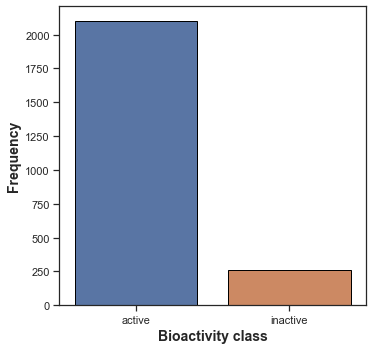

In [26]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='class', data=df_2class, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')

plt.savefig('plot_bioactivity_class.pdf')

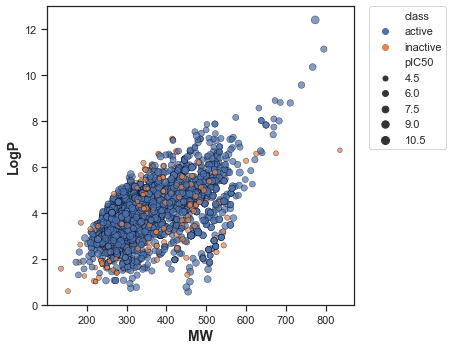

In [27]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=df_2class, hue='class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.savefig('plot_MW_vs_LogP.pdf')

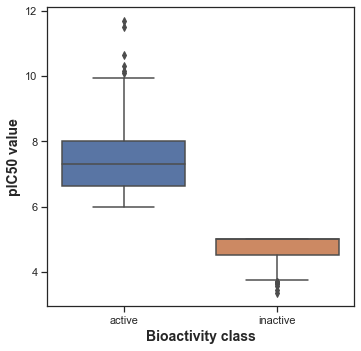

In [28]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'pIC50', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('pIC50 value', fontsize=14, fontweight='bold')

plt.savefig('plot_ic50.pdf')

In [30]:
mannwhitney('pIC50')

,Descriptor,Statistics,p,alpha,Interpretation
0,pIC50,0.0,9.209166e-153,0.05,Different distribution (reject H0)


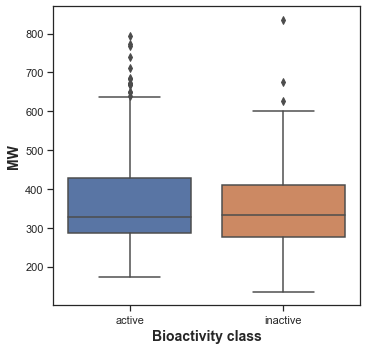

In [31]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'MW', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('MW', fontsize=14, fontweight='bold')

plt.savefig('plot_MW.pdf')

In [32]:
mannwhitney('MW')

,Descriptor,Statistics,p,alpha,Interpretation
0,MW,252968.0,0.029919,0.05,Different distribution (reject H0)


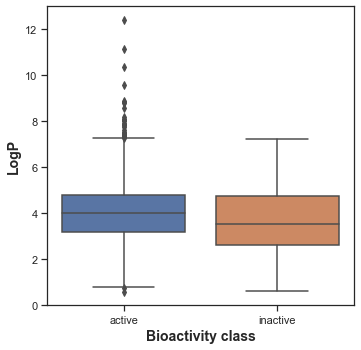

In [33]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'LogP', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')

plt.savefig('plot_LogP.pdf')

In [34]:
mannwhitney('LogP')

,Descriptor,Statistics,p,alpha,Interpretation
0,LogP,232531.0,0.000058,0.05,Different distribution (reject H0)


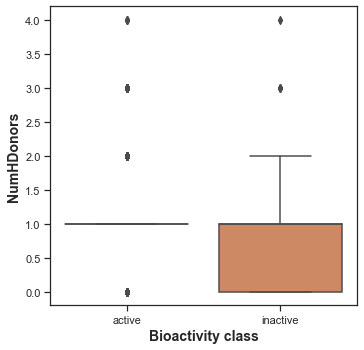

In [35]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHDonors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHDonors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHDonors.pdf')

In [36]:
mannwhitney('NumHDonors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHDonors,223926.5,1.113267e-07,0.05,Different distribution (reject H0)


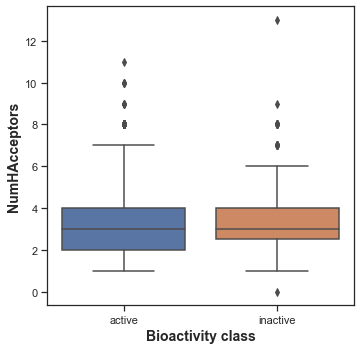

In [37]:
plt.figure(figsize=(5.5, 5.5))

sns.boxplot(x = 'class', y = 'NumHAcceptors', data = df_2class)

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('NumHAcceptors', fontsize=14, fontweight='bold')

plt.savefig('plot_NumHAcceptors.pdf')

In [38]:
mannwhitney('NumHAcceptors')

,Descriptor,Statistics,p,alpha,Interpretation
0,NumHAcceptors,231623.5,0.000026,0.05,Different distribution (reject H0)


In [14]:
df6 = pd.read_csv('human_sero_bioactivity_04_data_3class_pIC50.csv')
df6

,Unnamed: 0,molecule_chembl_id,canonical_smiles,class,MW,LogP,NumHDonors,NumHAcceptors,pIC50
0,0,CHEMBL322923,COC(=O)C1=C(c2ccc(Cl)c(Cl)c2)CC2CCC1C2,intermediate,311.208,4.74000,0.0,2.0,5.287350
1,1,CHEMBL435341,C/C=C\c1ccc([C@H]2CC3CCC([C@H]2C(=O)OC)N3C)cc1,active,299.414,3.45900,0.0,3.0,8.939302
2,2,CHEMBL311347,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccc(I)cc1)N2C,active,385.245,3.03050,0.0,3.0,8.376751
3,3,CHEMBL100941,COC(=O)C1C2CCC(C2)CC1c1ccc(Cl)c(Cl)c1,active,313.224,4.68620,0.0,2.0,7.476254
4,4,CHEMBL87031,COC(=O)C1C(c2ccc(Cl)c(Cl)c2)CC2CCC1N2C,active,328.239,3.73270,0.0,3.0,7.559091
...,...,...,...,...,...,...,...,...,...
2938,2938,CHEMBL4638599,O=c1n(CCCCN2CCN(c3cccc4sccc34)CC2)nc2ccccn12,active,407.543,3.31310,0.0,7.0,6.270107
2939,2939,CHEMBL4644352,O=c1n(CCCCN2CCN(c3cccc4sccc34)CC2)nc2c(F)cccn12,active,425.533,3.45220,0.0,7.0,6.517412
2940,2940,CHEMBL4634009,COc1cccc2nn(CCCCN3CCN(c4cccc5sccc45)CC3)c(=O)n12,active,437.569,3.32170,0.0,8.0,6.692504
2941,2941,CHEMBL4644391,N#Cc1ccc2nn(CCCCN3CCN(c4cccc5sccc45)CC3)c(=O)n2c1,active,432.553,3.18478,0.0,8.0,6.466482


In [10]:
selection = ['canonical_smiles','molecule_chembl_id']
df3_selection = df6[selection]
df3_selection.to_csv('molecule.smi', sep='\t', index=False, header=False)

In [27]:
df7 = pd.read_csv('molecule.smi')
df7

,COC(=O)C1=C(c2ccc(Cl)c(Cl)c2)CC2CCC1C2\tCHEMBL322923
0,C/C=C\c1ccc([C@H]2CC3CCC([C@H]2C(=O)OC)N3C)cc1...
1,COC(=O)[C@@H]1C2CC[C@H](C[C@@H]1c1ccc(I)cc1)N2...
2,COC(=O)C1C2CCC(C2)CC1c1ccc(Cl)c(Cl)c1\tCHEMBL1...
3,COC(=O)C1C(c2ccc(Cl)c(Cl)c2)CC2CCC1N2C\tCHEMBL...
4,COC(=O)C1C2CCC(CC1c1ccc(Cl)c(Cl)c1)O2\tCHEMBL3...
...,...
2937,O=c1n(CCCCN2CCN(c3cccc4sccc34)CC2)nc2ccccn12\t...
2938,O=c1n(CCCCN2CCN(c3cccc4sccc34)CC2)nc2c(F)cccn1...
2939,COc1cccc2nn(CCCCN3CCN(c4cccc5sccc45)CC3)c(=O)n...
2940,N#Cc1ccc2nn(CCCCN3CCN(c4cccc5sccc45)CC3)c(=O)n...


In [4]:

xml_files = glob.glob("*.xml")
xml_files.sort()
xml_files

['AtomPairs2DFingerprintCount.xml',
 'AtomPairs2DFingerprinter.xml',
 'EStateFingerprinter.xml',
 'ExtendedFingerprinter.xml',
 'Fingerprinter.xml',
 'GraphOnlyFingerprinter.xml',
 'KlekotaRothFingerprintCount.xml',
 'KlekotaRothFingerprinter.xml',
 'MACCSFingerprinter.xml',
 'PubchemFingerprinter.xml',
 'SubstructureFingerprintCount.xml',
 'SubstructureFingerprinter.xml']

In [5]:
#Creating a list of present files
FP_list = ['AtomPairs2DCount',
 'AtomPairs2D',
 'EState',
 'CDKextended',
 'CDK',
 'CDKgraphonly',
 'KlekotaRothCount',
 'KlekotaRoth',
 'MACCS',
 'PubChem',
 'SubstructureCount',
 'Substructure']

In [6]:
#Creating Data Dictionary
fp = dict(zip(FP_list, xml_files))
fp

{'AtomPairs2DCount': 'AtomPairs2DFingerprintCount.xml',
 'AtomPairs2D': 'AtomPairs2DFingerprinter.xml',
 'EState': 'EStateFingerprinter.xml',
 'CDKextended': 'ExtendedFingerprinter.xml',
 'CDK': 'Fingerprinter.xml',
 'CDKgraphonly': 'GraphOnlyFingerprinter.xml',
 'KlekotaRothCount': 'KlekotaRothFingerprintCount.xml',
 'KlekotaRoth': 'KlekotaRothFingerprinter.xml',
 'MACCS': 'MACCSFingerprinter.xml',
 'PubChem': 'PubchemFingerprinter.xml',
 'SubstructureCount': 'SubstructureFingerprintCount.xml',
 'Substructure': 'SubstructureFingerprinter.xml'}

In [5]:
#Importing PubChem
fp['PubChem']

'PubchemFingerprinter.xml'

In [7]:
#Setting the fingerprint module
 
 
fingerprint = 'PubChem'
 
fingerprint_output_file = ''.join([fingerprint,'.csv']) #Substructure.csv
fingerprint_descriptortypes = fp[fingerprint]
padeldescriptor(mol_dir='molecule.smi', 
                d_file=fingerprint_output_file, #'Substructure.csv'
                #descriptortypes='SubstructureFingerprint.xml', 
                descriptortypes= fingerprint_descriptortypes,
                detectaromaticity=True,
                standardizenitro=True,
                standardizetautomers=True,
                threads=2,
                removesalt=True,
                log=True,
                fingerprints=True)

In [10]:
df3_X = pd.read_csv(fingerprint_output_file)
df3_X

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL322923,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL435341,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL311347,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL100941,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL87031,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2938,CHEMBL4638599,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2939,CHEMBL4644352,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2940,CHEMBL4634009,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2941,CHEMBL4644391,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
df3_X = df3_X.drop(columns=['Name'])
df3_X

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2938,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2939,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2940,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2941,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [15]:
df3_Y = df6['pIC50']
df3_Y

0       5.287350
1       8.939302
2       8.376751
3       7.476254
4       7.559091
          ...   
2938    6.270107
2939    6.517412
2940    6.692504
2941    6.466482
2942    8.023650
Name: pIC50, Length: 2943, dtype: float64

In [16]:
dataset3 = pd.concat([df3_X,df3_Y], axis=1)
dataset3

,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,PubchemFP9,...,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880,pIC50
0,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,5.287350
1,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,8.939302
2,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,8.376751
3,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.476254
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,7.559091
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2938,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.270107
2939,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.517412
2940,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.692504
2941,1,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,6.466482


In [17]:
dataset3.to_csv('human_serotonin_bioactivity_06_data_3class_pIC50_pubchem_fp.csv', index=False)

In [3]:
df7 = pd.read_csv('human_serotonin_bioactivity_06_data_3class_pIC50_pubchem_fp.csv')

In [4]:
X = df7.drop('pIC50', axis=1)
X
Y = df7.pIC50
Y

0      5.29
1      8.94
2      8.38
3      7.48
4      7.56
       ... 
2938   6.27
2939   6.52
2940   6.69
2941   6.47
2942   8.02
Name: pIC50, Length: 2943, dtype: float64

In [5]:

selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

In [10]:
model = RandomForestRegressor(n_estimators=100)
model.fit(X_train, Y_train)
r2 = model.score(X_test, Y_test)
r2

0.5317863204772094

In [11]:
Y_pred = model.predict(X_test)

<function matplotlib.pyplot.show(close=None, block=None)>

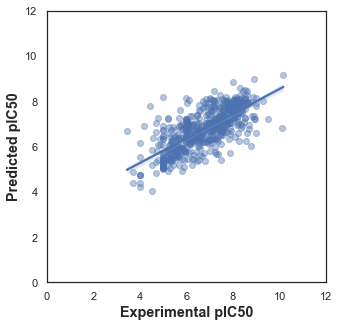

In [15]:


sns.set(color_codes=True)
sns.set_style("white")

ax = sns.regplot(Y_test, Y_pred, scatter_kws={'alpha':0.4})
ax.set_xlabel('Experimental pIC50', fontsize='large', fontweight='bold')
ax.set_ylabel('Predicted pIC50', fontsize='large', fontweight='bold')
ax.set_xlim(0, 12)
ax.set_ylim(0, 12)
ax.figure.set_size_inches(5, 5)
plt.show

In [17]:
import pickle
pickle.dump(model, open('sert_model.pkl', 'wb'))

In [8]:
X = df7.drop('pIC50', axis=1)
Y = df7.pIC50

In [9]:
# Examine X dimension
X.shape

(2943, 881)

In [15]:
# Remove low variance features
selection = VarianceThreshold(threshold=(.8 * (1 - .8)))    
X = selection.fit_transform(X)
X.shape

(2943, 139)

In [11]:
# Perform data splitting using 80/20 ratio
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [12]:
X_train.shape, Y_train.shape

((2354, 139), (2354,))

In [18]:
# Defines and builds the lazyclassifier
clf = LazyRegressor(verbose=0,ignore_warnings=True, custom_metric=None)
train,test = clf.fit(X_train, X_train, Y_train, Y_train)

100%|██████████| 42/42 [00:37<00:00,  1.12it/s]


In [19]:
train

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
DecisionTreeRegressor,0.89,0.90,0.38,0.08
ExtraTreeRegressor,0.89,0.90,0.38,0.08
ExtraTreesRegressor,0.89,0.90,0.38,3.70
GaussianProcessRegressor,0.89,0.90,0.38,2.65
XGBRegressor,0.86,0.87,0.43,1.31
RandomForestRegressor,0.85,0.85,0.45,2.61
BaggingRegressor,0.83,0.84,0.48,0.41
MLPRegressor,0.80,0.81,0.52,5.31
HistGradientBoostingRegressor,0.72,0.74,0.61,3.24


In [20]:
test

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
DecisionTreeRegressor,0.89,0.90,0.38,0.08
ExtraTreeRegressor,0.89,0.90,0.38,0.08
ExtraTreesRegressor,0.89,0.90,0.38,3.70
GaussianProcessRegressor,0.89,0.90,0.38,2.65
XGBRegressor,0.86,0.87,0.43,1.31
RandomForestRegressor,0.85,0.85,0.45,2.61
BaggingRegressor,0.83,0.84,0.48,0.41
MLPRegressor,0.80,0.81,0.52,5.31
HistGradientBoostingRegressor,0.72,0.74,0.61,3.24


[(0.0, 1.0)]

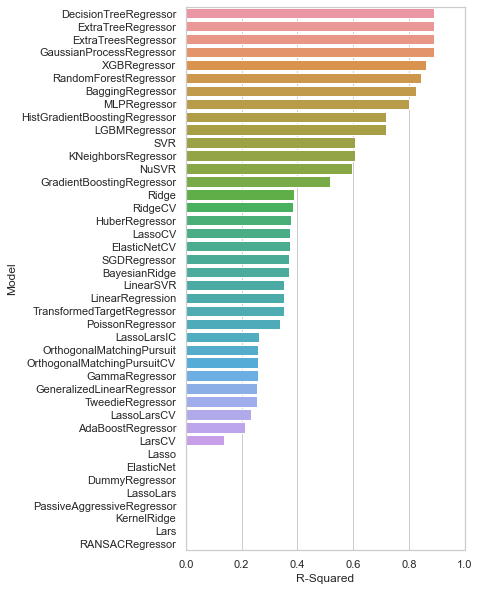

In [24]:


train["R-Squared"] = [0 if i < 0 else i for i in train.iloc[:,0] ]

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=train.index, x="R-Squared", data=train)
ax.set(xlim=(0, 1))


[(0.0, 10.0)]

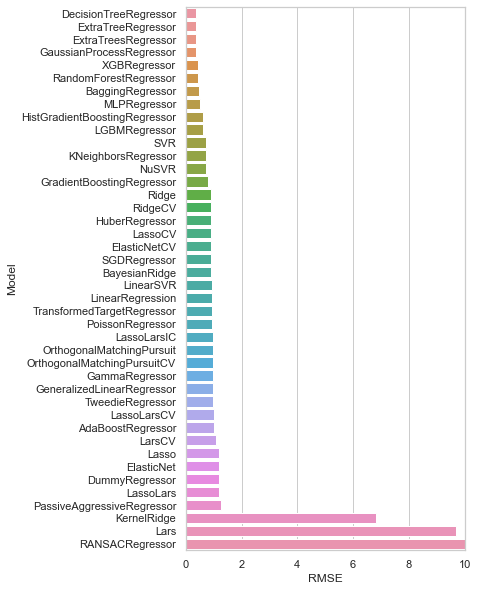

In [27]:
# Bar plot of RMSE values

plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=train.index, x="RMSE", data=train)
ax.set(xlim=(0, 10))

[(0.0, 10.0)]

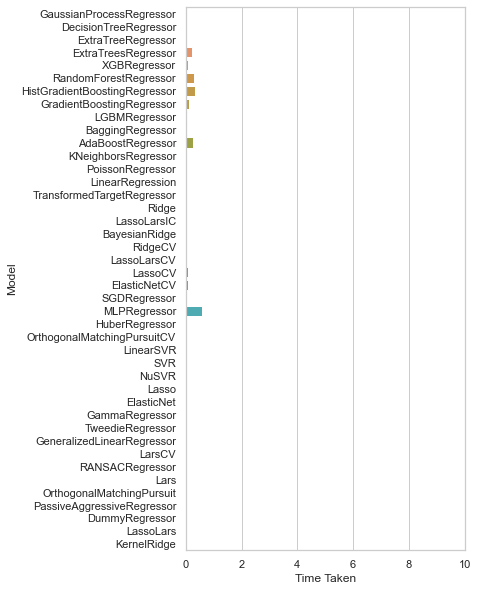

In [30]:
# Bar plot of calculation time
plt.figure(figsize=(5, 10))
sns.set_theme(style="whitegrid")
ax = sns.barplot(y=train.index, x="Time Taken", data=train)
ax.set(xlim=(0, 10))